In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import seaborn as sns
from matplotlib.ticker import ScalarFormatter
import numpy as np

plt.style.use('_mpl-gallery-nogrid')

figs_path = Path('/home/dev/masters-thesis/tex/figs')

path = '/home/dev/masters-thesis/documents/QnA_OSM.xlsx'

questions_df = pd.read_excel(path, sheet_name='Questions').dropna(how='all')
tests_df = pd.read_excel(path, sheet_name='Tests').dropna(how='all')
levels_df = pd.read_excel(path, sheet_name='Prompt Levels').dropna(how='all')
levels_tests_df = pd.read_excel(path, sheet_name='PL Tests').dropna(how='all')

levels_tests_df = levels_tests_df.merge(levels_df, on='Query ID', how='left')

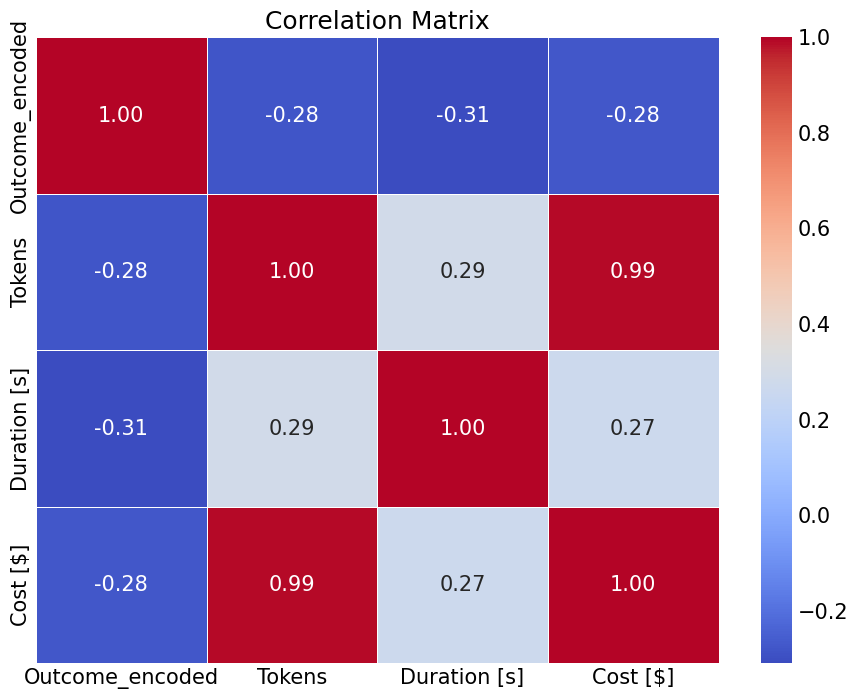

In [4]:
font_size = 15
plt.rcParams.update({'font.size': font_size})

custom_mapping = {
    'success': 2,
    'partial success': 1,
    'failure': 0
}

tests_df['Outcome_encoded'] = tests_df['Outcome'].map(custom_mapping)

correlation_matrix = tests_df[['Outcome_encoded',
                         'Tokens', 'Duration [s]', 'Cost [$]']].corr()

plt.figure(figsize=(9, 7))
sns.heatmap(correlation_matrix, annot=True,
            cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix')
plt.tight_layout(pad=0.5)
plt.savefig(figs_path / 'correlation_matrix.png')
plt.show()

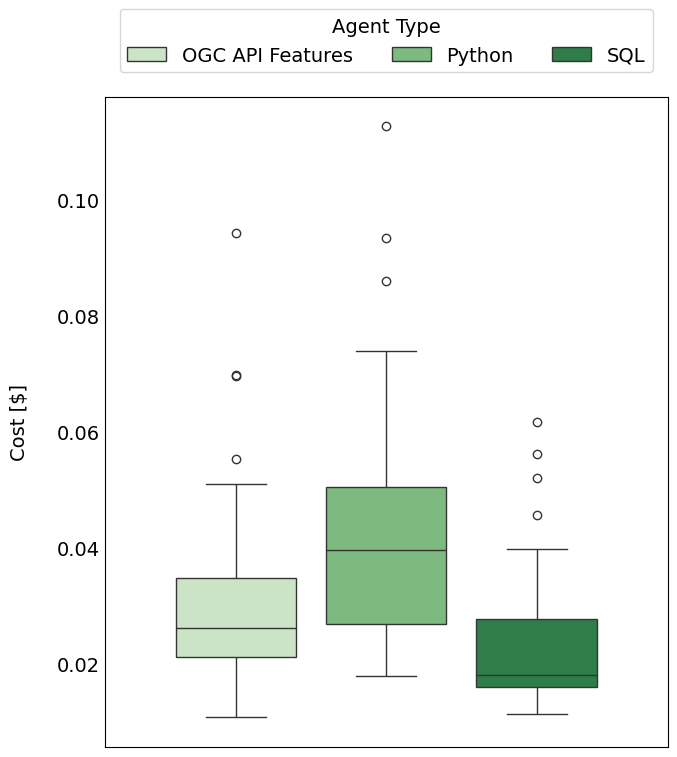

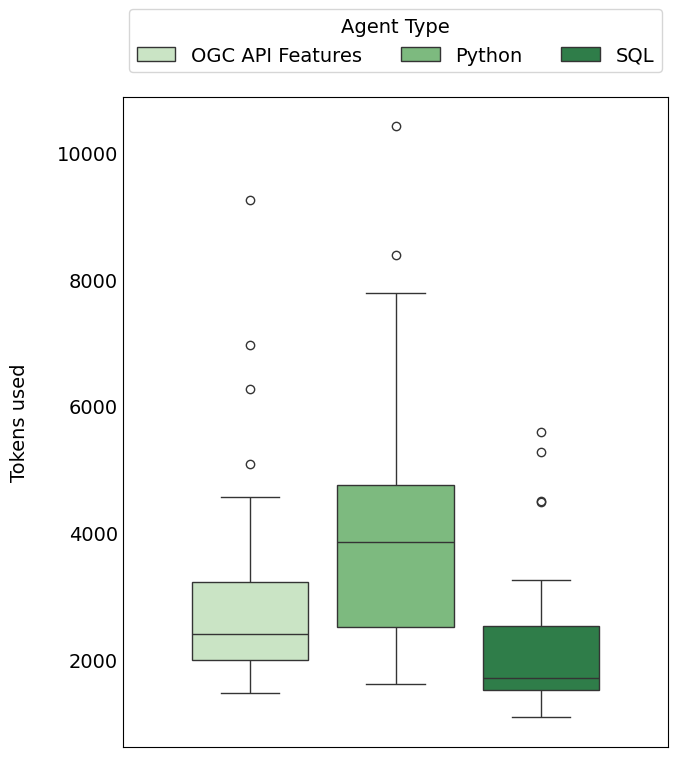

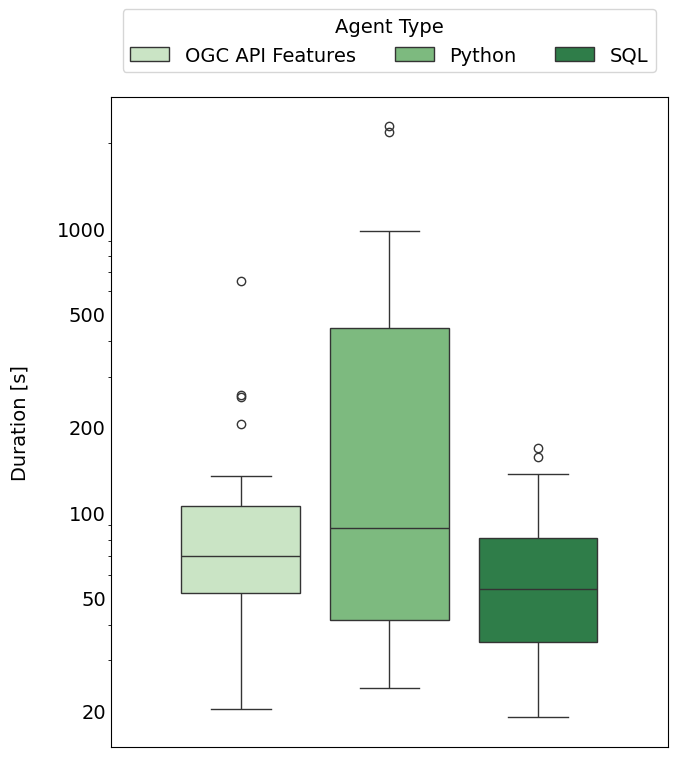

In [5]:
def setup_plot(data, y_var, hue_var, y_label, palette="Greens", figsize=(7, 8)):
    plt.rcParams.update({'font.size': 14})
    fig, ax = plt.subplots(figsize=figsize)
    sns.boxplot(hue=hue_var, y=y_var, data=data,
                palette=palette, ax=ax, gap=.2)
    ax.set_ylabel(y_label, labelpad=20)
    return fig, ax


def finalize_plot(fig, ax, handles, legend_labels, figs_path, filename):
    plt.legend(loc='upper center', handles=handles, labels=legend_labels,
               bbox_to_anchor=(0.5, 1.15), fancybox=True, shadow=False, ncol=3, title="Agent Type")
    plt.tight_layout()
    plt.savefig(figs_path / filename)
    plt.show()

def plot_cost(data, figs_path):
    fig, ax = setup_plot(data, "Cost [$]", "Agent Type", "Cost [$]")
    handles, _ = ax.get_legend_handles_labels()
    finalize_plot(fig, ax, handles, [
                  "OGC API Features", "Python", "SQL"], figs_path, 'cost_box_plot.png')

def plot_tokens(data, figs_path):
    fig, ax = setup_plot(data, "Tokens", "Agent Type", "Tokens used")
    handles, _ = ax.get_legend_handles_labels()
    finalize_plot(fig, ax, handles, [
                  "OGC API Features", "Python", "SQL"], figs_path, 'tokens_box_plot.png')

def plot_duration(data, figs_path):
    fig, ax = setup_plot(data, "Duration [s]", "Agent Type", "Duration [s]")
    ax.set_yscale('log')
    ax.set_yticks([20, 50, 100, 200, 500, 1000])
    ax.get_yaxis().set_major_formatter(ScalarFormatter())
    handles, _ = ax.get_legend_handles_labels()
    finalize_plot(fig, ax, handles, [
                  "OGC API Features", "Python", "SQL"], figs_path, 'duration_box_plot.png')


plot_cost(tests_df, figs_path)
plot_tokens(tests_df, figs_path)
plot_duration(tests_df, figs_path)

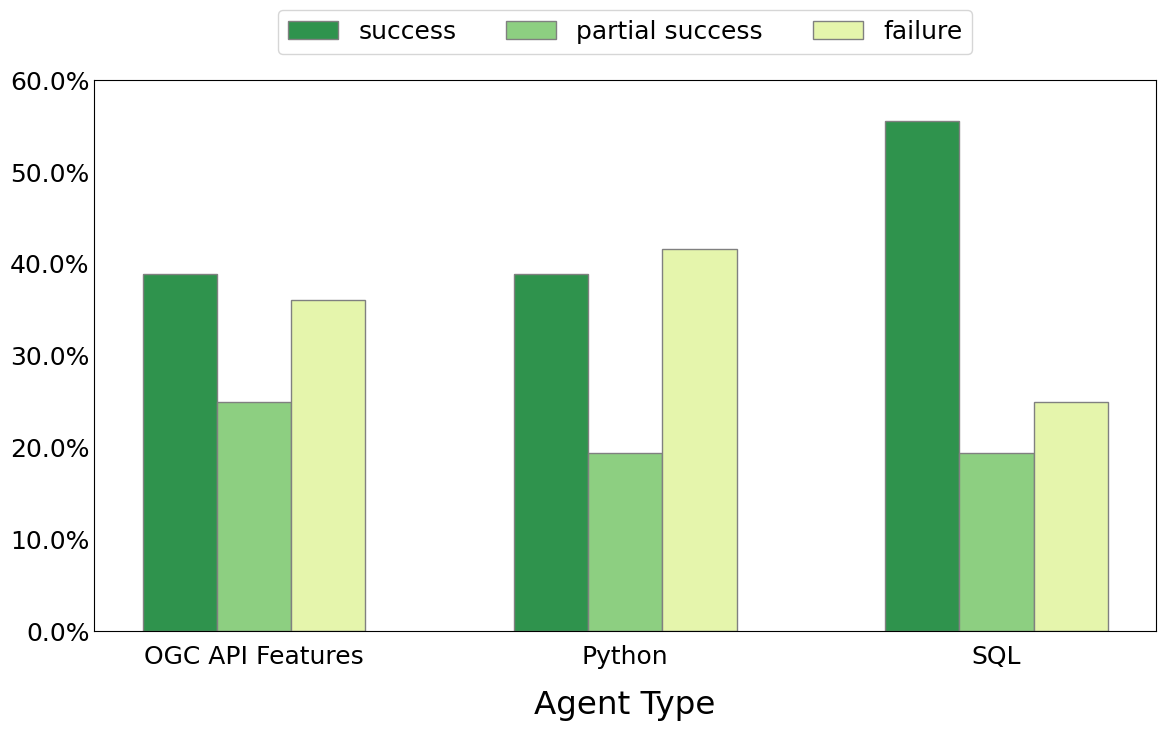

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

font_size = 18
plt.rcParams.update({'font.size': font_size})
barWidth = 0.2
fig, ax = plt.subplots(figsize=(12, 8))

# Combine data processing steps into a single function


def process_outcomes(df, outcomes, groupby_col):
    total_counts = df.groupby(groupby_col).size().reset_index(name='total')
    outcome_data = {}

    for outcome in outcomes:
        count_df = df[df['Outcome'] == outcome].groupby(
            groupby_col).size().reset_index(name='count')
        all_agent_types = df[groupby_col].unique()
        count_df = count_df.set_index(groupby_col).reindex(
            all_agent_types, fill_value=0).reset_index()
        count_df = count_df.merge(total_counts, on=groupby_col)
        count_df['percentage'] = 100 * count_df['count'] / count_df['total']
        outcome_data[outcome] = count_df.sort_values(by=groupby_col)

    return outcome_data


# Define the outcomes you are interested in
outcomes = ['success', 'partial success', 'failure']
outcome_data = process_outcomes(tests_df, outcomes, 'Agent Type')

# Plotting
colors = plt.get_cmap('YlGn')(np.linspace(0.7, 0.2, len(outcomes)))
bars = []

for i, outcome in enumerate(outcomes):
    bars.append([x + barWidth * i for x in range(len(outcome_data[outcome]))])
    ax.bar(bars[i], outcome_data[outcome]['percentage'], color=colors[i], width=barWidth,
           edgecolor='grey', label=outcome)

plt.xlabel('Agent Type', fontsize=font_size * 1.3, labelpad=15)
plt.xticks([r + barWidth for r in range(len(outcome_data[outcomes[0]]))],
           ['OGC API Features', 'Python', 'SQL'])

y_max = max(df['percentage'].max() for df in outcome_data.values()) + 10
ax.set_yticks(np.arange(0, min(y_max, 101), 10))
ax.set_yticklabels([f'{x}%' for x in np.arange(0, min(y_max, 101), 10)])
plt.tick_params(axis='x', which='major', pad=10)

plt.legend(loc='upper center', bbox_to_anchor=(
    0.5, 1.15), fancybox=True, shadow=False, ncol=3)
plt.tight_layout()

plt.savefig(figs_path / 'outcome_distribution_bar_chart.png')
plt.show()

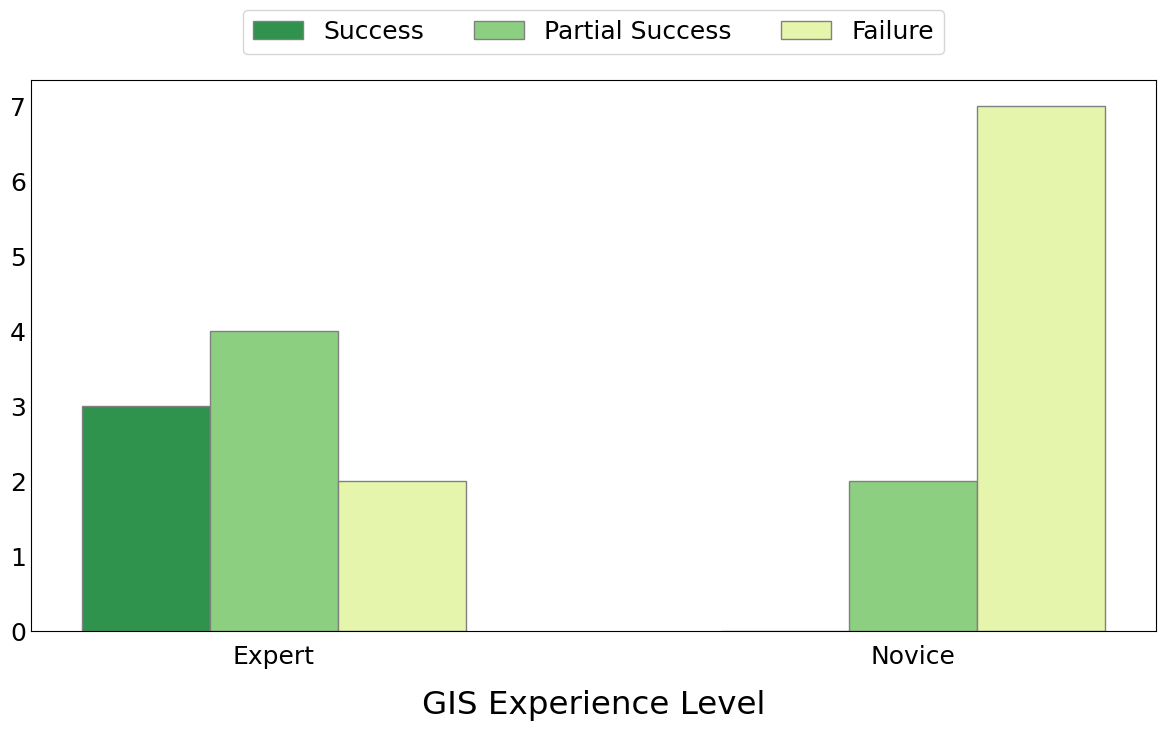

In [8]:
font_size = 18
plt.rcParams.update({'font.size': font_size})
barWidth = 0.2
fig = plt.subplots(figsize=(12, 8))


success_count = counter(levels_tests_df, 'success')
partial_success_count = counter(levels_tests_df, 'partial success')
failure_count = counter(levels_tests_df, 'failure')

br1 = np.arange(len(success_count))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]

colors = plt.get_cmap('YlGn')(np.linspace(0.2, 0.7, 3))

plt.bar(br1, success_count['count'], color=colors[2], width=barWidth,
        edgecolor='grey', label='Success')
plt.bar(br2, partial_success_count['count'], color=colors[1], width=barWidth,
        edgecolor='grey', label='Partial Success')
plt.bar(br3, failure_count['count'], color=colors[0], width=barWidth,
        edgecolor='grey', label='Failure')

max_count = max(success_count['count'].max(),
                partial_success_count['count'].max(),
                failure_count['count'].max())
plt.xlabel('GIS Experience Level', fontsize=font_size * 1.3, labelpad=15)
plt.yticks(range(int(max_count) + 1))
plt.xticks([r + barWidth for r in range(len(success_count))],
           ['Expert', 'Novice'])
plt.tick_params(axis='x', which='major', pad=10)


plt.legend(loc='upper center', bbox_to_anchor=(
    0.5, 1.15), fancybox=True, shadow=False, ncol=3)
plt.tight_layout()
plt.savefig(figs_path / 'levels_outcome_distribution_bar_chart.png')
plt.show()